# Design of the Capacitor DAC for 6-bit SAR A/D Converter

*   Status: work in progress


This notebook aims to build a binary-weighted charge-redistribution DAC such as the the schematic shown below.

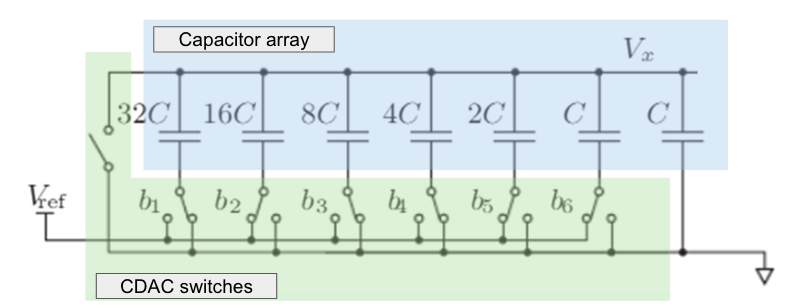

## Included PCells:
  - Transmission gate
  - MIM capacitor array

##Contributor: Team SaltyChip (from Chipathon 2024)

*   Chipathon2024 PCell of transmission gate GitHub:
https://github.com/tsengs0/OpenFASOC/tree/chipathon2024_saltychip/openfasoc/generators/glayout/glayout/flow/blocks/elementary/transmission_gate
*   Chipathon2024 GitHub:
https://github.com/sscs-ose/sscs-ose-chipathon.github.io










In [ ]:
# Setup the environment for the OpenFASOC GDSFactory generator
# You only need to run this block once!

# Clone OpenFASoC and switch to the our working branch
!git clone https://github.com/tsengs0/chipathon2024_SaltyChip.git
%cd chipathon2024_SaltyChip
!git checkout chipathon2024_saltychip

# Install python dependencies
!pip install sky130
!pip install gf180 prettyprinttree svgutils
!pip install gdsfactory==7.7.0

import pathlib
import os
# Install KLayout (via conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
# Install from the litex-hub channel
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        klayout \
                        magic \
                        netgen

Cloning into 'chipathon2024_SaltyChip'...
remote: Enumerating objects: 16772, done.
remote: Counting objects: 100% (4023/4023), done.
remote: Compressing objects: 100% (619/619), done.
remote: Total 16772 (delta 3506), reused 3683 (delta 3392), pack-reused 12749 (from 1)
Receiving objects: 100% (16772/16772), 410.63 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (10288/10288), done.
Updating files: 100% (1856/1856), done.
/content/chipathon2024_SaltyChip/openfasoc/generators/glayout/chipathon2024_SaltyChip
Already on 'chipathon2024_saltychip'
Your branch is up to date with 'origin/chipathon2024_saltychip'.
  Using cached gdsfactory-8.5.6-py3-none-any.whl.metadata (11 kB)
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached kfactory-0.18.4-py3-none-any.whl.metadata (4.4 kB)
  Using cached trimesh-4.4.9-py3-none-any.whl.metadata (18 kB)
  Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached

Add the klayout binary to your system path and move it to the GLayout directory. (Must be run every time the kernel is rebooted.)





In [ ]:
# Setup the environment for the OpenFASOC GDSFactory generator

# Adding micro-mamba binary directory to the PATH
# This directory contains Klayout
import pathlib
import os
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())

%env CONDA_PREFIX={CONDA_PREFIX}
# Add conda packages to the PATH
PATH = os.environ['PATH']
%env PATH={PATH}:{CONDA_PREFIX}/bin

%cd /content/chipathon2024_SaltyChip/openfasoc/generators/glayout
!git checkout chipathon2024_saltychip

env: CONDA_PREFIX=/content/chipathon2024_SaltyChip/openfasoc/generators/glayout/chipathon2024_SaltyChip/conda-env
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/chipathon2024_SaltyChip/conda-env/bin:/content/chipathon2024_SaltyChip/openfasoc/generators/glayout/chipathon2024_SaltyChip/conda-env/bin
/content/chipathon2024_SaltyChip/openfasoc/generators/glayout
Already on 'chipathon2024_saltychip'
Your branch is up to date with 'origin/chipathon2024_saltychip'.


# To import the necessary glayout packages

In [ ]:
from datetime import datetime
from typing import ClassVar, Optional, Any, Union, Literal, Iterable, TypedDict
import math
#from glayout.flow.pdk.gf180_mapped import gf180
from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
from glayout.flow.pdk.mappedpdk import MappedPDK
from glayout.flow.pdk.util.comp_utils import evaluate_bbox
from glayout.flow.pdk.util.port_utils import set_port_orientation, rename_ports_by_orientation, create_private_ports
from gdsfactory import Component
from gdsfactory.cell import cell
from gdsfactory.components import rectangle
from glayout.flow.primitives.fet import pmos
from glayout.flow.primitives.fet import nmos
from glayout.flow.routing.straight_route import straight_route
from glayout.flow.routing.c_route import c_route
from glayout.flow.routing.L_route import L_route
from glayout.flow.routing.smart_route import smart_route
from glayout.flow.placement.two_transistor_interdigitized import two_pfet_interdigitized, two_nfet_interdigitized, two_transistor_interdigitized
from glayout.flow.placement.common_centroid_ab_ba import common_centroid_ab_ba
from glayout.flow.pdk.util.comp_utils import prec_ref_center, movey, evaluate_bbox, align_comp_to_port, prec_center, prec_array
from glayout.flow.primitives.via_gen import via_stack, via_array
from gdsfactory.cell import cell
from glayout.flow.spice import Netlist
from glayout.flow.pdk.util.snap_to_grid import component_snap_to_grid
from glayout.flow.primitives.guardring import tapring

from glayout.flow.primitives.mimcap import mimcap, mimcap_array


# To layout the transmission gate

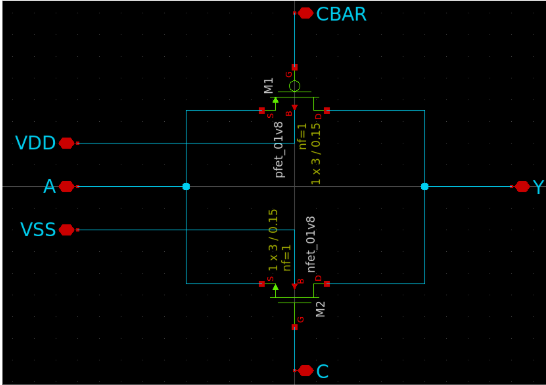

In [ ]:
def transmission_gate_netlist(
	pdk: MappedPDK,
	width: float,
	multipliers: int,
	length: float,
	subckt_only: Optional[bool] = False
) -> Netlist:
	if length is None:
		length = pdk.get_grule('poly')['min_width']
	if width is None:
		width = 3
	mtop = multipliers if subckt_only else 1
	model_pmos = pdk.models['pfet']
	model_nmos = pdk.models['nfet']
	print(f"model_pmos: {model_pmos}")
	source_netlist = """.subckt {circuit_name} {nodes} """ + f'l={length} w={width} m={mtop} ' + """
XM1 Y C A VDD {model_pmos} l={{l}} w={{w}} m={{m}}
XM2 Y CBAR A VSS {model_nmos} l={{l}} w={{w}} m={{m}}"""
	source_netlist += "\n.ends {circuit_name}"

	instance_format = "X{name} {nodes} {circuit_name} l={length} w={width} m={mult}"

	return Netlist(
		circuit_name='tg',
		nodes=['Y', 'C', 'CBAR', 'A'],
		source_netlist=source_netlist,
  		instance_format=instance_format,
		parameters={
			'model_pmos': model_pmos,
			'model_nmos': model_nmos,
			'width': width,
   			'length': length,
			'mult': multipliers
   		}
	)

def short_width_tg(
	pdk: MappedPDK,
	component_name: str = "tg",
	with_substrate_tap: bool = False,
	fet_min_width: float = 3,
	pmos_width: float = 3,
	pmos_length: float = 0.15,
	nmos_width: float = 3,
	nmos_length: float = 0.15,
	add_pin: bool = True, # For LVS
	**kwargs
) -> Component:

	# To prepare all necessary cells to construct a transmission gate, i.e.
	# 1) PMOS
	# 2) NMOS
	pfet = pmos(pdk=pdk, gate_rmult=1, with_tie=False, with_substrate_tap=False, with_dummy=(True, True), width=pmos_width, length=pmos_length)
	nfet = nmos(pdk=pdk, gate_rmult=1, with_tie=False, with_dnwell=False, with_substrate_tap=False, with_dummy=(True, True), width=nmos_width, length=nmos_length)
	top_level = Component(name=component_name)
	pfet_ref = prec_ref_center(pfet)
	nfet_ref = prec_ref_center(nfet)
	top_level.add(pfet_ref)
	top_level.add(nfet_ref)

	# Placement (1)
	#  a) To vertically flip the NMOS such that the its gate point toward the PMOS's gate
	#  b) To move the PMOS above the NMOS
	mos_spacing = pdk.util_max_metal_seperation()
	rename_ports_by_orientation(nfet_ref.mirror_y())
	pfet_ref.movey(evaluate_bbox(nfet)[1] + mos_spacing)

	# Add the ports aligned with the basic PMOS and NMOS
	top_level.add_ports(pfet_ref.get_ports_list(), prefix="pmos_")
	top_level.add_ports(nfet_ref.get_ports_list(), prefix="nmos_")

	# Placement (2):
	#  a) Add a bunch of met1-to-met2 vias attached to the mcron-layered points inside the source of PMOS/NMOS
	#  b) Add a bunch of met1-to-met2 vias attached to the mcron-layered points inside the drain of PMOS/NMOS
	fet_source_finger_num = 1
	fet_drain_finger_num = 1
	finger_col_num = 1
	finger_row_num = math.floor((fet_min_width*0.5) / (2*pdk.get_grule("met2")["min_width"]))-1 # To pave the stacked vias over all bottom half
	pmos_source_sdvias = list()
	nmos_source_sdvias = list()
	pmos_drain_sdvias = list()
	nmos_drain_sdvias = list()
	pmos_source_sdvias_ref = list()
	nmos_source_sdvias_ref = list()
	pmos_drain_sdvias_ref = list()
	nmos_drain_sdvias_ref = list()
	sdvias_row = [via_stack(pdk=pdk, glayer1="met2", glayer2="met3", fullbottom=True, fulltop=True) for i in range(finger_col_num)]
	for row in range(finger_row_num):
		pmos_source_sdvias.append(sdvias_row)
		nmos_source_sdvias.append(sdvias_row)
		pmos_drain_sdvias.append(sdvias_row)
		nmos_drain_sdvias.append(sdvias_row)

		pmos_source_cols_ref = list()
		nmos_source_cols_ref = list()
		pmos_drain_cols_ref = list()
		nmos_drain_cols_ref = list()
		for col in range(finger_col_num):
			# For source terminals of the PMOS and NMOS
			temp_ref = prec_ref_center(pmos_source_sdvias[row][col])
			pmos_source_cols_ref.append(temp_ref)
			temp_ref = prec_ref_center(nmos_source_sdvias[row][col])
			nmos_source_cols_ref.append(temp_ref)
			# For drain terminals of the PMOS and NMOS
			temp_ref = prec_ref_center(pmos_drain_sdvias[row][col])
			pmos_drain_cols_ref.append(temp_ref)
			temp_ref = prec_ref_center(nmos_drain_sdvias[row][col])
			nmos_drain_cols_ref.append(temp_ref)

		pmos_source_sdvias_ref.append(pmos_source_cols_ref)
		nmos_source_sdvias_ref.append(nmos_source_cols_ref)
		pmos_drain_sdvias_ref.append(pmos_drain_cols_ref)
		nmos_drain_sdvias_ref.append(nmos_drain_cols_ref)
		top_level.add(pmos_source_sdvias_ref[row][col] for col in range(finger_col_num))
		top_level.add(nmos_source_sdvias_ref[row][col] for col in range(finger_col_num))
		top_level.add(pmos_drain_sdvias_ref[row][col] for col in range(finger_col_num))
		top_level.add(nmos_drain_sdvias_ref[row][col] for col in range(finger_col_num))

	# Placement (3):
	#  a) Move all the a part of particular stacked vias such that they are connected to the source of PMOS/NMOS
	#  b) Move all the a part of particular stacked vias such that they are connected to the drain of PMOS/NMOS
	y_offset = pdk.get_grule("met3")["min_separation"]+pdk.get_grule("met3")["min_width"]
	x_offset = abs(top_level.ports["pmos_multiplier_0_leftsd_array_row0_col0_bottom_via_N"].center[0]-pfet_ref.center[0])
	for row in range(finger_row_num):
		# Moving the positions of the stacked vias associated with the PMOS
		pmos_source_sdvias_ref[row][0].movex(-x_offset)
		pmos_source_sdvias_ref[row][0].movey(evaluate_bbox(nfet)[1]+mos_spacing-(y_offset*row))
		pmos_drain_sdvias_ref[row][0].movex(x_offset)
		pmos_drain_sdvias_ref[row][0].movey(evaluate_bbox(nfet)[1]+mos_spacing-(y_offset*row))

		# Moving the positions fo the stacked vias associated with NMOS
		nmos_source_sdvias_ref[row][0].movex(-x_offset)
		nmos_source_sdvias_ref[row][0].movey(y_offset*row)
		nmos_drain_sdvias_ref[row][0].movex(x_offset)
		nmos_drain_sdvias_ref[row][0].movey(y_offset*row)

	# Routing
	#   a) PMOS.source connected to NMOS.source by placing a large MET2-layered rectangle
	#   b) PMOS.drain connected to NMOS.drain by placing a large MET2-layered rectangle
	print("nmos_source_sdvias_ref.len: ", nmos_source_sdvias_ref)
	sdvias_connection = Component()
	sdvias_connection.add_polygon(
		[
			(nmos_source_sdvias_ref[0][finger_col_num-1].xmin, nmos_source_sdvias_ref[0][finger_col_num-1].ymin),#leftBottom_pos
			(pmos_source_sdvias_ref[0][finger_col_num-1].xmin, pmos_source_sdvias_ref[0][finger_col_num-1].ymax),#leftTop_pos
			(pmos_source_sdvias_ref[0][0].xmax, pmos_source_sdvias_ref[0][0].ymax),#rightTop_pos
			(nmos_source_sdvias_ref[0][0].xmax, nmos_source_sdvias_ref[0][0].ymin) #rightBottom_pos
		],
		layer=pdk.get_glayer("met3")
	)
	sdvias_connection.add_polygon(
		[
			(nmos_drain_sdvias_ref[0][finger_col_num-1].xmin, nmos_drain_sdvias_ref[0][finger_col_num-1].ymin),#leftBottom_pos
			(pmos_drain_sdvias_ref[0][finger_col_num-1].xmin, pmos_drain_sdvias_ref[0][finger_col_num-1].ymax),#leftTop_pos
			(pmos_drain_sdvias_ref[0][0].xmax, pmos_drain_sdvias_ref[0][0].ymax),#rightTop_pos
			(nmos_drain_sdvias_ref[0][0].xmax, nmos_drain_sdvias_ref[0][0].ymin) #rightBottom_pos
		],
		layer=pdk.get_glayer("met3")
	)
	sdvias_connection_ref = top_level.add_ref(sdvias_connection)

	# Add pins w/ labels for LVS
	if add_pin == True:
		top_level.unlock()
		pin_info = list() # list that contains all port and component information
		met1_pin=(pdk.get_glayer("met1")[0], 16)
		met1_label=(pdk.get_glayer("met1")[0], 5)
		port_size = (0.24, 0.24)
		# --- Port: A, i.e. input of the transmission gate
		A_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		A_pin.add_label(text="A", layer=met1_label)
		pin_info.append((A_pin, top_level.ports.get(f"nmos_source_W"), ('r', 't')))
		# --- Port: Y, i.e. output of the transmission gate
		Y_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		Y_pin.add_label(text="Y", layer=met1_label)
		pin_info.append((Y_pin, top_level.ports.get(f"nmos_drain_E"), ('l', 't')))
		# --- Port: C, i.e. gate control to the NMOS
		C_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		C_pin.add_label(text="C", layer=met1_label)
		pin_info.append((C_pin, top_level.ports.get(f"nmos_gate_S"), None))
		# --- Port: CBAR, i.e. gate control to the PMOS
		CBAR_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		CBAR_pin.add_label(text="CBAR", layer=met1_label)
		pin_info.append((CBAR_pin, top_level.ports.get(f"pmos_gate_N"), None))

		# Move everythin to position
		for comp, prt, alignment in pin_info:
			alignment = ('c', 'b') if alignment is None else alignment
			comp_ref = align_comp_to_port(comp, prt, alignment=alignment)
			top_level.add(comp_ref)

	# Add substrate tap
	if with_substrate_tap:
		substrate_tap = tapring(pdk, enclosed_rectangle=pdk.snap_to_2xgrid(evaluate_bbox(top_level.flatten(),padding=pdk.util_max_metal_seperation())))
		substrate_tap_ref = top_level << movey(substrate_tap,destination=pdk.snap_to_2xgrid(top_level.flatten().center[1],snap4=True))
		top_level.add_ports(substrate_tap_ref.get_ports_list(),prefix="substratetap_")

	top_level = component_snap_to_grid(rename_ports_by_orientation(top_level))
	top_level.info['netlist'] = transmission_gate_netlist(
		pdk,
  		width=kwargs.get('width', pmos_width), length=kwargs.get('length', pmos_length), multipliers=1,
		subckt_only=True
	)
	top_level.info['netlist'].generate_netlist()
	return top_level

def long_width_tg(
	pdk: MappedPDK,
	component_name: str = "tg",
	fet_min_width: float = 3,
	pmos_width: float = 12,
	pmos_length: float = 0.15,
	nmos_width: float = 12,
	nmos_length: float = 0.15,
	with_substrate_tap: bool = True,
	add_pin: bool = True, # For LVS
	**kwargs
) -> Component:
	# To calculate the number of fingers for the underlying PMOS/NMOS layout
	finger_num = math.ceil(pmos_width / fet_min_width)

	# To prepare all necessary cells to construct a transmission gate, i.e.
	# 1) PMOS
	# 2) NMOS
	pfet = pmos(pdk=pdk, multipliers=1, fingers=finger_num, interfinger_rmult=1, gate_rmult=1, with_tie=False, with_substrate_tap=False, with_dummy=(True, True), width=fet_min_width, length=pmos_length)
	nfet = nmos(pdk=pdk, multipliers=1, fingers=finger_num, interfinger_rmult=1, gate_rmult=1, with_tie=False, with_dnwell=False, with_substrate_tap=False, with_dummy=(True, True), width=fet_min_width, length=nmos_length)
	top_level = Component(name=component_name)
	pfet_ref = prec_ref_center(pfet)
	nfet_ref = prec_ref_center(nfet)
	top_level.add(pfet_ref)
	top_level.add(nfet_ref)

	# Placement (1)
	#  a) To vertically flip the NMOS such that the its gate point toward the PMOS's gate
	#  b) To move the PMOS above the NMOS
	mos_spacing = pdk.util_max_metal_seperation()
	rename_ports_by_orientation(nfet_ref.mirror_y()) #
	pfet_ref.movey(evaluate_bbox(nfet)[1] + mos_spacing)

	# Placement (2):
	#  a) Add a bunch of met1-to-met2 vias attached to the mcron-layered points inside the source of PMOS/NMOS
	fet_source_finger_num = math.ceil((finger_num+1) / 2)
	fet_drain_finger_num = finger_num+1-fet_source_finger_num
	fet_source_fingerL_num = (fet_source_finger_num-1)/2 # excluding the centered one
	fet_drain_fingerL_num = fet_drain_finger_num/2
	finger_col_num = fet_source_finger_num # A half of the fingers belongs to drain
	finger_row_num = math.floor((fet_min_width*0.5) / (2*pdk.get_grule("met2")["min_width"]))-1 # To pave the stacked vias over all bottom half
#	print(f"finger_row_num: {finger_row_num}, finger_col_num: {finger_col_num}")
	pmos_source_sdvias = list()
	nmos_source_sdvias = list()
	pmos_source_sdvias_ref = list()
	nmos_source_sdvias_ref = list()
	sdvias_row = [via_stack(pdk=pdk, glayer1="met2", glayer2="met3", fullbottom=True, fulltop=True) for i in range(finger_col_num)]
	for row in range(finger_row_num):
		pmos_source_sdvias.append(sdvias_row)
		nmos_source_sdvias.append(sdvias_row)

		pmos_temp_ref = list()
		nmos_temp_ref = list()
		for col in range(finger_col_num):
			temp_ref = prec_ref_center(pmos_source_sdvias[row][col])
			pmos_temp_ref.append(temp_ref)
			temp_ref = prec_ref_center(nmos_source_sdvias[row][col])
			nmos_temp_ref.append(temp_ref)

		pmos_source_sdvias_ref.append(pmos_temp_ref)
		nmos_source_sdvias_ref.append(nmos_temp_ref)
		top_level.add(pmos_source_sdvias_ref[row][col] for col in range(finger_col_num))
		top_level.add(nmos_source_sdvias_ref[row][col] for col in range(finger_col_num))

	# Placement (3):
	#  a) Move all the a part of particular stacked vias such that they are connected to the source of PMOS/NMOS
	centroid_index = math.floor(fet_source_finger_num/2)
	y_offset = pdk.get_grule("met3")["min_separation"]+pdk.get_grule("met3")["min_width"]
	x_s2d_offset = abs(pfet_ref.ports["multiplier_0_leftsd_array_row0_col0_bottom_via_S"].center[0]-pfet_ref.ports["multiplier_0_row0_col0_rightsd_array_row0_col0_bottom_via_S"].center[0])
	x_offset = x_s2d_offset*2 # Distance between one soure finger to another source finger at its left-/right-hand side is (S-to-D distance)*2
	for row in range(finger_row_num):
		x_spacing = x_offset*centroid_index # initial value
		for col in range(finger_col_num):
			# Moving the positions of the stacked vias associated with the PMOS
			pmos_source_sdvias_ref[row][col].movey(evaluate_bbox(nfet)[1]+mos_spacing-(y_offset*row))
			pmos_source_sdvias_ref[row][col].movex(x_spacing)

			# Moving the positions fo the stacked vias associated with NMOS
			nmos_source_sdvias_ref[row][col].movey(y_offset*row) # In NMOS, the row_0 is exactly placed at the center position (0, 0),
			                                                     # thereby no need for moving the stacked vias of row_0, i.e. movey by 0
			nmos_source_sdvias_ref[row][col].movex(x_spacing)

			x_spacing = x_spacing-x_offset

	# Routing
	# To simplify the routing for the parallel-gate transistors, the layout is realised as follow which is expected to be equivalent to a TG
	#     a) PMOS.source connected to NMOS.source by placing a large MET2-layered rectangle
	#     b) PMOS.drain connected to NMOS.drain
	source_connection = Component()
	source_connection.add_polygon(
		[
			(nmos_source_sdvias_ref[0][finger_col_num-1].xmin, nmos_source_sdvias_ref[0][finger_col_num-1].ymin),#leftBottom_pos
			(pmos_source_sdvias_ref[0][finger_col_num-1].xmin, pmos_source_sdvias_ref[0][finger_col_num-1].ymax),#leftTop_pos
			(pmos_source_sdvias_ref[0][0].xmax, pmos_source_sdvias_ref[0][0].ymax),#rightTop_pos
			(nmos_source_sdvias_ref[0][0].xmax, nmos_source_sdvias_ref[0][0].ymin) #rightBottom_pos
		],
		layer=pdk.get_glayer("met3")
	)
	source_connection = top_level.add_ref(source_connection)
	top_level << c_route(pdk, pfet_ref.ports["drain_E"], nfet_ref.ports["drain_E"], cglayer="met3") # "out" of the TG

	# Add the ports aligned with the basic PMOS and NMOS
	top_level.add_ports(pfet_ref.get_ports_list(), prefix="pmos_")
	top_level.add_ports(nfet_ref.get_ports_list(), prefix="nmos_")

	# Add pins w/ labels for LVS
	if add_pin == True:
		top_level.unlock()
		pin_info = list() # list that contains all port and component information
		met1_pin=(pdk.get_glayer("met1")[0], 20)
		met1_label=(pdk.get_glayer("met1")[0], 5)
		port_size = (0.24, 0.24)
		# --- Port: A, i.e. input of the transmission gate
		A_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		A_pin.add_label(text="A", layer=met1_label)
		pin_info.append((A_pin, top_level.ports.get(f"nmos_source_S"), None))
		# --- Port: Y, i.e. output of the transmission gate
		Y_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		Y_pin.add_label(text="Y", layer=met1_label)
		pin_info.append((Y_pin, top_level.ports.get(f"nmos_drain_S"), None))
		# --- Port: C, i.e. gate control to the NMOS
		C_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		C_pin.add_label(text="C", layer=met1_label)
		pin_info.append((C_pin, top_level.ports.get(f"nmos_gate_S"), None))
		# --- Port: CBAR, i.e. gate control to the PMOS
		CBAR_pin=rectangle(layer=met1_pin, size=port_size, centered=True).copy()
		CBAR_pin.add_label(text="CBAR", layer=met1_label)
		pin_info.append((CBAR_pin, top_level.ports.get(f"pmos_gate_N"), None))

		# Move everythin to position
		for comp, prt, alignment in pin_info:
			alignment = ('c', 'b') if alignment is None else alignment
			comp_ref = align_comp_to_port(comp, prt, alignment=alignment)
			top_level.add(comp_ref)

	# Add substrate tap
	if with_substrate_tap:
		substrate_tap = tapring(pdk, enclosed_rectangle=pdk.snap_to_2xgrid(evaluate_bbox(top_level.flatten(),padding=pdk.util_max_metal_seperation())))
		substrate_tap_ref = top_level << movey(substrate_tap,destination=pdk.snap_to_2xgrid(top_level.flatten().center[1],snap4=True))
		top_level.add_ports(substrate_tap_ref.get_ports_list(),prefix="substratetap_")

	top_level = component_snap_to_grid(rename_ports_by_orientation(top_level))
	top_level.info['netlist'] = transmission_gate_netlist(
		pdk,
  		width=kwargs.get('width', pmos_width), length=kwargs.get('length', pmos_length), multipliers=finger_num,
		subckt_only=True
	)
	top_level.info['netlist'].generate_netlist()

	return top_level

@cell
def tg_cell(
	pdk: MappedPDK,
	component_name: str = "tg",
	fet_min_width: float = 3,
	pmos_width: float = 12,
	pmos_length: float = 0.15,
	nmos_width: float = 12,
	nmos_length: float = 0.15,
	add_pin: bool = True, # For LVS
	with_substrate_tap: bool = True,
	**kwargs
) -> Component:
	if pmos_width != nmos_width:
		raise ValueError("PCell constraint: the widths of PMOS and NMOS must be identical")
	elif pmos_width > fet_min_width: # Long-width PMOS and NMOS
		if (pmos_width % (fet_min_width*4)) != 0:
			raise ValueError(f"PCell constraint: the widths of PMOS and NMOS must be a multiple of {fet_min_width*4} um, however the given width is {pmos_width} um")
		else:
			tg = long_width_tg(
				pdk=pdk,
				component_name=component_name,
				fet_min_width=fet_min_width,
				pmos_width=pmos_width,
				pmos_length=pmos_length,
				nmos_width=nmos_width,
				nmos_length=nmos_length,
				with_substrate_tap=True,
				add_pin=True
			)
	else: # Short-width PMOS and NMOS
		tg = short_width_tg(
			pdk=pdk,
			component_name=component_name,
			fet_min_width=fet_min_width,
			pmos_width=pmos_width,
			pmos_length=pmos_length,
			nmos_width=nmos_width,
			nmos_length=nmos_length,
			with_substrate_tap=True,
			add_pin=True
		)

	return tg

# To evaluate the layout of the underlying transmission gate, e.g. exporting GDS, DRC, LVS, etc.

In [ ]:
TARGET_PDK = sky130
#PWD_OUTPUT = subprocess.run(['pwd'], capture_output=True, text=True)
#GDS_DIR = PWD_OUTPUT.stdout.strip() + "/gds"
GDS_DIR = "/content/gds"

# Design constraints
fet_min_width=3 # 3 um

# Design configuration
pmos_width  = 12
pmos_length = 0.15
nmos_width  = 12
nmos_length = 0.15

def basic_tg_eval():
	tg_dut = tg_cell(
		pdk=TARGET_PDK,
		component_name="tg",
		fet_min_width=fet_min_width,
		pmos_width=pmos_width,
		pmos_length=pmos_length,
		nmos_width=nmos_width,
		nmos_length=nmos_length,
		with_substrate_tap=True,
		add_pin=True
	)

	print(tg_dut.info["netlist"].generate_netlist())
	tg_dut.write_gds(f"{GDS_DIR}/tg.gds")
	return tg_dut

Display the layout

Detail:
https://github.com/tsengs0/OpenFASOC/blob/chipathon2024_saltychip/openfasoc/generators/glayout/glayout/flow/blocks/elementary/transmission_gate/transmission_gate.py

In [ ]:
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(f"{GDS_DIR}/tg.svg")
  # Scale the image for displaying
  fig = sg.fromfile(f"{GDS_DIR}/tg.svg")
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(f"{GDS_DIR}/tg.svg")

  # Display the image
  IPython.display.display(IPython.display.SVG(f"{GDS_DIR}/tg.svg"))

tg_dut = basic_tg_eval()
#display_gds(f"{GDS_DIR}/tg.gds")

model_pmos: sky130_fd_pr__pfet_01v8


2024-12-06 06:42:32.458 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/content/gds/tg.gds'




.subckt tg Y C CBAR A l=0.15 w=12.0 m=4 
XM1 Y C A VDD sky130_fd_pr__pfet_01v8 l={l} w={w} m={m}
XM2 Y CBAR A VSS sky130_fd_pr__nfet_01v8 l={l} w={w} m={m}
.ends tg


# Launch the DRC of the underlying PCell




In [ ]:
now = datetime.now() # Get the current date and time
regression_id = now.strftime('%Y%m%d%H%M%S') # Format the date and time without spaces
magic_drc_result = sky130.drc_magic(
	layout=tg_dut,
	design_name=tg_dut.name,
	output_file=f"/content/gds/tg_{regression_id}_drc.rpt"
)
print(f"Magic DRC result ({tg_dut.name}): \n", magic_drc_result)
print("--------------------------------------")
#netgen_lvs_result = sky130.lvs_netgen(
#    layout=tg_dut,
#		design_name=tg_dut.name,
#		output_file_path=f"/content/gds/tg_{regression_id}_lvs.rpt",
#		copy_intermediate_files=True
#)

2024-12-06 06:42:32.474 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmps0c3we14/tg_cell_471429cf.gds'


using default pdk_root: /usr/bin/miniconda3/share/pdk/
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 465 - Compiled on Tue Mar 19 23:17:55 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Loading "/tmp/tmps0c3we14/magic_commands.tcl" from command line.
[INFO]: Loading tg_cell_471429cf

Creating new cell
No errors found.
[INFO]: DONE with /tmp/tmps0c3we14/tg_cell_471429cf.rpt

Using technology "minimum", version 0.0

Soft errors: 
Don't know how to read GDS-II:
Nothing in "cifinput" section of tech file.
Cell tg_cell_471429cf couldn't be read
No such file or directory

Magic DRC result (tg_cell_471429cf): 
 {'result_str': 'magic drc script passed\nNo errors found in DRC report', 'subproc_code': 0}
--------------------------------------


# MIM capacitor array

We prepared a MIM capacitor array for 6bit-DAC.

Refered to the following paper, we design a common centroid layout.


In [ ]:
def create_6bit_dac_mimcap_array(pdk: MappedPDK):
    """
    Creates a 6-bit DAC using an 8x8 MIM capacitor array with binary weighting.
    """

    # Crate the top-level component
    dac_mim_cap = Component("6bit_DAC_MIMCAP_Array")

    # metal and via layers
    met2 = pdk.get_glayer('met3')
    #print("met2:",met2)
    met3_capmetbottom = pdk.get_glayer('met4')
    #print("met3_capmetbottom:",met3_capmetbottom)
    met4_capmettop = pdk.get_glayer('met5')
    #print("met4_capmettop:",met4_capmettop)
    via3 = pdk.get_glayer('via4')
    mimcap_arr = Component("mimcap_arr")
    mimcap_single_size = 6
    mimcap_single = mimcap(pdk, size=(mimcap_single_size,mimcap_single_size))
    rows_num = 8
    columns_num = 8
    mimcap_space = 12*pdk.get_grule("capmet")["min_separation"]
    met4_width = pdk.get_grule("met5")["min_width"]
    array_ref = mimcap_arr << prec_array(mimcap_single, rows=rows_num, columns=columns_num, spacing=2*[mimcap_space])
    mimcap_arr.add_ports(array_ref.get_ports_list())
    mim_metal_space = mimcap_space/9

    port_pairs = list()
    port_sides_pairs = list()
    via_refs = list()
    global top_c5_left
    global top_c5_right
    global top_c5_center
    global top_c4_left
    global top_c4_right
    global top_c4_center
    global top_c3_left
    global top_c3_right
    global top_c3_center
    global top_c2_left
    global top_c2_right
    global top_c2_center
    for rownum in  range(rows_num):
        for colnum in range(columns_num):
            base_mimcap = f"row{rownum}_col{colnum}_"
            right_mimcap = f"row{rownum}_col{colnum+1}_"
            up_mimcap = f"row{rownum+1}_col{colnum}_"
            capmetbottom = "met4"
            capmettop = "met5"

            # Bottom Metal
            level = "bottom_met_"
            layer = capmetbottom
            base_east_port = mimcap_arr.ports.get(base_mimcap+level+"E")
            right_west_port = mimcap_arr.ports.get(right_mimcap+level+"W")
            base_north_port = mimcap_arr.ports.get(base_mimcap+level+"N")
            up_south_port = mimcap_arr.ports.get(up_mimcap+level+"S")
            if rownum == rows_num-1 and colnum == columns_num-1:
                pass #continue
            elif rownum == rows_num-1:
                port_pairs.append((base_east_port,right_west_port,layer))
            elif colnum == columns_num-1:
                port_pairs.append((base_north_port,up_south_port,layer))
            else:
                port_pairs.append((base_east_port,right_west_port,layer))
                port_pairs.append((base_north_port,up_south_port,layer))
            if rownum == 0 and colnum == 7:
                base_south_port = mimcap_arr.ports.get(base_mimcap+level+"S")
                base_south_port_down = base_south_port.copy()
                base_south_port_down.center[1] -= mimcap_single_size
                via_ref = mimcap_arr << straight_route(pdk, base_south_port, base_south_port_down, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
                mimcap_arr.add_ports(via_ref.get_ports_list(), prefix="via_commonbottom_") # via_commonbottom_route_X
                via_south_port = mimcap_arr.ports.get("via_commonbottom_route_S")
                via_south_port_down = via_south_port.copy()
                via_south_port_down.layer = met2
                via_south_port_down.center[1] -= mimcap_single_size*2
                mimcap_arr << straight_route(pdk, via_south_port, via_south_port_down, width=met4_width, glayer1="met3", glayer2="met3", via1_alignment=("c","c"))

            # Top metal
            level = "top_met_"
            position_up = "up_"
            position_down = "down_"
            position_right = "right_"
            position_left = "left_"
            layer = capmettop

            base_east_port = mimcap_arr.ports.get(base_mimcap+level+"E")
            base_west_port = mimcap_arr.ports.get(base_mimcap+level+"W")
            met4_distance_from_center = base_east_port.width/2 - 3*pdk.get_grule(layer)["min_width"]
            if base_east_port is not None:
                base_west_port_up = base_west_port.copy()
                base_west_port_up.name = base_mimcap+position_up+level+"W"
                base_west_port_up.center[1] += met4_distance_from_center
                base_west_port_up_space3 = base_west_port_up.copy()
                base_west_port_up_space3.center[0] -= mim_metal_space*3
                base_west_port_down = base_west_port.copy()
                base_west_port_down.name = base_mimcap+position_down+level+"W"
                base_west_port_down.center[1] -= met4_distance_from_center
                base_west_port_down_space3 = base_west_port_down.copy()
                base_west_port_down_space3.center[0] -= mim_metal_space*3
                base_east_port_up = base_east_port.copy()
                base_east_port_up.name = base_mimcap+position_up+level+"E"
                base_east_port_up.center[1] += met4_distance_from_center #(base_east_port_up.width/2 - pdk.get_grule(layer)["min_width"])
                base_east_port_up_space1 = base_east_port_up.copy()
                base_east_port_up_space1.name = base_mimcap+position_up+level+"W"
                base_east_port_up_space1.center[0] += mim_metal_space*1
                base_east_port_up_space2 = base_east_port_up.copy()
                base_east_port_up_space2.name = base_mimcap+position_up+level+"W"
                base_east_port_up_space2.center[0] += mim_metal_space*2
                base_east_port_up_space3 = base_east_port_up.copy()
                base_east_port_up_space3.name = base_mimcap+position_up+level+"W"
                base_east_port_up_space3.center[0] += mim_metal_space*3
                base_east_port_up_space4 = base_east_port_up.copy()
                base_east_port_up_space4.name = base_mimcap+position_up+level+"W"
                base_east_port_up_space4.center[0] += mim_metal_space*4
                base_east_port_down = base_east_port.copy()
                base_east_port_down.name = base_mimcap+position_down+level+"E"
                base_east_port_down.center[1] -= met4_distance_from_center #(base_north_port.width/2 - pdk.get_grule(layer)["min_width"])
                base_east_port_down_space1 = base_east_port_down.copy()
                base_east_port_down_space1.name = base_mimcap+position_down+level+"W"
                base_east_port_down_space1.center[0] += mim_metal_space*1
                base_east_port_down_space2 = base_east_port_down.copy()
                base_east_port_down_space2.name = base_mimcap+position_down+level+"W"
                base_east_port_down_space2.center[0] += mim_metal_space*2
                base_east_port_down_space3 = base_east_port_down.copy()
                base_east_port_down_space3.name = base_mimcap+position_down+level+"W"
                base_east_port_down_space3.center[0] += mim_metal_space*3
                base_east_port_down_space4 = base_east_port_down.copy()
                base_east_port_down_space4.name = base_mimcap+position_down+level+"W"
                base_east_port_down_space4.center[0] += mim_metal_space*4

            right_west_port = mimcap_arr.ports.get(right_mimcap+level+"W")
            if right_west_port is not None:
                right_west_port_up = right_west_port.copy()
                right_west_port_up.name = right_mimcap+position_up+level+"W"
                right_west_port_up.center[1] += met4_distance_from_center #(right_west_port_up.width/2 - pdk.get_grule(layer)["min_width"])
                right_west_port_up_space3 = right_west_port_up.copy()
                right_west_port_up_space3.name = right_mimcap+position_up+level+"E"
                right_west_port_up_space3.center[0] -= mim_metal_space*3
                right_west_port_up_space4 = right_west_port_up.copy()
                right_west_port_up_space4.name = right_mimcap+position_up+level+"E"
                right_west_port_up_space4.center[0] -= mim_metal_space*4
                right_west_port_up_space6 = right_west_port_up.copy()
                right_west_port_up_space6.name = right_mimcap+position_up+level+"E"
                right_west_port_up_space6.center[0] -= mim_metal_space*6
                right_west_port_up_space7 = right_west_port_up.copy()
                right_west_port_up_space7.name = right_mimcap+position_up+level+"E"
                right_west_port_up_space7.center[0] -= mim_metal_space*7
                right_west_port_down = right_west_port.copy()
                right_west_port_down.name = right_mimcap+position_down+level+"W"
                right_west_port_down.center[1] -= met4_distance_from_center #(right_west_port_down.width/2 - pdk.get_grule(layer)["min_width"])
                right_west_port_down_space3 = right_west_port_down.copy()
                right_west_port_down_space3.name = right_mimcap+position_down+level+"E"
                right_west_port_down_space3.center[0] -= mim_metal_space*3
                right_west_port_down_space4 = right_west_port_down.copy()
                right_west_port_down_space4.name = right_mimcap+position_down+level+"E"
                right_west_port_down_space4.center[0] -= mim_metal_space*4
                right_west_port_down_space6 = right_west_port_down.copy()
                right_west_port_down_space6.name = right_mimcap+position_down+level+"E"
                right_west_port_down_space6.center[0] -= mim_metal_space*6
                right_west_port_down_space7 = right_west_port_down.copy()
                right_west_port_down_space7.name = right_mimcap+position_down+level+"E"
                right_west_port_down_space7.center[0] -= mim_metal_space*7

            base_north_port = mimcap_arr.ports.get(base_mimcap+level+"N")
            if base_north_port is not None:
                base_north_port_right = base_north_port.copy()
                base_north_port_right.name = base_mimcap+position_right+level+"N"
                base_north_port_right.center[0] += met4_distance_from_center #(base_north_port_right.width/2 - pdk.get_grule(layer)["min_width"])
                base_north_port_right_space = base_north_port_right.copy()
                base_north_port_right_space.name = base_mimcap+position_right+level+"S"
                base_north_port_right_space.center[1] += mim_metal_space*4
                base_north_port_left = base_north_port.copy()
                base_north_port_left.name = base_mimcap+position_left+level+"N"
                base_north_port_left.center[0] -= met4_distance_from_center #(base_north_port_left.width/2 - pdk.get_grule(layer)["min_width"])
                base_north_port_left_space = base_north_port_left.copy()
                base_north_port_left_space.name = base_mimcap+position_left+level+"S"
                base_north_port_left_space.center[1] += mim_metal_space*4

            up_south_port = mimcap_arr.ports.get(up_mimcap+level+"S")
            if up_south_port is not None:
                up_south_port_right = up_south_port.copy()
                up_south_port_right.name = base_mimcap+position_right+level+"S"
                up_south_port_right.center[0] += met4_distance_from_center #(up_south_port_right.width/2 - pdk.get_grule(layer)["min_width"])
                up_south_port_right_space = up_south_port_right.copy()
                up_south_port_right_space.name = base_mimcap+position_right+level+"N"
                up_south_port_right_space.center[1] -= mim_metal_space*4
                up_south_port_left = up_south_port.copy()
                up_south_port_left.name = base_mimcap+position_left+level+"S"
                up_south_port_left.center[0] -= met4_distance_from_center #(up_south_port_left.width/2 - pdk.get_grule(layer)["min_width"])
                up_south_port_left_space = up_south_port_left.copy()
                up_south_port_left_space.name = base_mimcap+position_left+level+"N"
                up_south_port_left_space.center[1] -= mim_metal_space*4

            if rownum == 0:
                # North and South
                if colnum in (2,3,5,6):
                    port_pairs.append((base_north_port_right,base_north_port_right_space,layer))
                    port_pairs.append((base_north_port_left,base_north_port_left_space,layer))
                    port_pairs.append((up_south_port_right,up_south_port_right_space,layer))
                    port_pairs.append((up_south_port_left,up_south_port_left_space,layer))
                else:
                    port_pairs.append((base_north_port_left,up_south_port_left,layer))
                    port_pairs.append((base_north_port_right,up_south_port_right,layer))
                # West and East
                if colnum in (5,6): #(2,6)
                    port_pairs.append((base_east_port_up,base_east_port_up_space2,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space2,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space6, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space6, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 0:
                    mimcap_arr << straight_route(pdk, base_west_port_up, base_west_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_west_port_down, base_west_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
            elif rownum == 1:
                # North and South
                if colnum in (1,2,4,5):
                    port_pairs.append((base_north_port_right,base_north_port_right_space,layer))
                    port_pairs.append((base_north_port_left,base_north_port_left_space,layer))
                    port_pairs.append((up_south_port_right,up_south_port_right_space,layer))
                    port_pairs.append((up_south_port_left,up_south_port_left_space,layer))
                else:
                    port_pairs.append((base_north_port_left,up_south_port_left,layer))
                    port_pairs.append((base_north_port_right,up_south_port_right,layer))
                # West and East
                if colnum in (0,2,3,5): #(4,4)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum in (1,6): #(2,6)
                    port_pairs.append((base_east_port_up,base_east_port_up_space2,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space2,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space6, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space6, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == 4: #(4,3)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 0:
                    mimcap_arr << straight_route(pdk, base_west_port_up, base_west_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_west_port_down, base_west_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
            elif rownum == 2:
                # North and South
                if colnum in (0,1,2,3,4,5,7):
                    port_pairs.append((base_north_port_right,base_north_port_right_space,layer))
                    port_pairs.append((base_north_port_left,base_north_port_left_space,layer))
                    port_pairs.append((up_south_port_right,up_south_port_right_space,layer))
                    port_pairs.append((up_south_port_left,up_south_port_left_space,layer))
                else:
                    port_pairs.append((base_north_port_left,up_south_port_left,layer))
                    port_pairs.append((base_north_port_right,up_south_port_right,layer))
                # West and East
                if colnum == 4: #(4,4)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum == 5: #(3,4)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum in (0,6): #(2,6)
                    port_pairs.append((base_east_port_up,base_east_port_up_space2,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space2,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space6, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space6, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == 3: #(4,3)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 0:
                    mimcap_arr << straight_route(pdk, base_west_port_up, base_west_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_west_port_down, base_west_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
            elif rownum == 3:
                # North and South
                if colnum in (0,1,2,3,5,6,7):
                    port_pairs.append((base_north_port_right,base_north_port_right_space,layer))
                    port_pairs.append((base_north_port_left,base_north_port_left_space,layer))
                    port_pairs.append((up_south_port_right,up_south_port_right_space,layer))
                    port_pairs.append((up_south_port_left,up_south_port_left_space,layer))
                else:
                    port_pairs.append((base_north_port_left,up_south_port_left,layer))
                    port_pairs.append((base_north_port_right,up_south_port_right,layer))
                # West and East
                if colnum in (0,1): #(3,4)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum == 2: #(3,3)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == 3: #(4,4)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 7:
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
            elif rownum == 4:
                # North and South
                if colnum in (0,2,3,4,5,6,7):
                    port_pairs.append((base_north_port_right,base_north_port_right_space,layer))
                    port_pairs.append((base_north_port_left,base_north_port_left_space,layer))
                    port_pairs.append((up_south_port_right,up_south_port_right_space,layer))
                    port_pairs.append((up_south_port_left,up_south_port_left_space,layer))
                else:
                    port_pairs.append((base_north_port_left,up_south_port_left,layer))
                    port_pairs.append((base_north_port_right,up_south_port_right,layer))
                # West and East
                if colnum == 2: #(4,4)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum == 3: #(3,4)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum in (5,6): #(2,6)
                    port_pairs.append((base_east_port_up,base_east_port_up_space2,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space2,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space6, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space6, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == 4: #(4,3)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 0:
                    mimcap_arr << straight_route(pdk, base_west_port_up, base_west_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_west_port_down, base_west_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
            elif rownum == 5:
                # North and South
                if colnum in (2,3,5,6):
                    port_pairs.append((base_north_port_right,base_north_port_right_space,layer))
                    port_pairs.append((base_north_port_left,base_north_port_left_space,layer))
                    port_pairs.append((up_south_port_right,up_south_port_right_space,layer))
                    port_pairs.append((up_south_port_left,up_south_port_left_space,layer))
                else:
                    port_pairs.append((base_north_port_left,up_south_port_left,layer))
                    port_pairs.append((base_north_port_right,up_south_port_right,layer))
                # West and East
                if colnum == 2: #(4,4)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))

                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum in (3,6): #(3,4)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum == 1: #(2,6)
                    port_pairs.append((base_east_port_up,base_east_port_up_space2,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space2,layer))
                    mimcap_arr << straight_route(pdk, right_west_port_up, right_west_port_up_space6, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, right_west_port_down, right_west_port_down_space6, width=met4_width, glayer1="met5", glayer2="met3")
                elif colnum == 0: #(3,3)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space3,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space3,layer))
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 7:
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
            elif rownum == 6:
                # North and South
                if colnum in (1,2,4,5):
                    port_pairs.append((base_north_port_right,base_north_port_right_space,layer))
                    port_pairs.append((base_north_port_left,base_north_port_left_space,layer))
                    port_pairs.append((up_south_port_right,up_south_port_right_space,layer))
                    port_pairs.append((up_south_port_left,up_south_port_left_space,layer))
                else:
                    port_pairs.append((base_north_port_left,up_south_port_left,layer))
                    port_pairs.append((base_north_port_right,up_south_port_right,layer))
                # West and East
                if colnum in (2,5): #(3,4)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum in (1,3,4,6): #(4,4)
                    port_pairs.append((base_east_port_up,base_east_port_up_space4,layer))
                    port_pairs.append((base_east_port_down,base_east_port_down_space4,layer))
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum == 0: #(3,3)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space3,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space3,layer))
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 7:
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
            elif rownum == 7:
                # West and East
                if colnum == 1: #(3,4)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space4,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space4,layer))
                elif colnum == 0: #(3,3)
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width, glayer1="met5", glayer2="met3")
                    port_pairs.append((right_west_port_up,right_west_port_up_space3,layer))
                    port_pairs.append((right_west_port_down,right_west_port_down_space3,layer))
                elif colnum == columns_num-1:
                    pass #continue
                else:
                    port_pairs.append((base_east_port_up,right_west_port_up,layer))
                    port_pairs.append((base_east_port_down,right_west_port_down,layer))
                if colnum == 7:
                    mimcap_arr << straight_route(pdk, base_east_port_up, base_east_port_up_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))
                    mimcap_arr << straight_route(pdk, base_east_port_down, base_east_port_down_space3, width=met4_width*3, glayer1="met5", glayer2="met3", via2_alignment=("c","c"))

                # metal2
                layer = "met3"
                base_east_port_metal2_up = mimcap_arr.ports.get(base_mimcap+level+"E")
                base_east_port_metal2_up.name = base_mimcap+"east_metal2_up"
                base_east_port_metal2_up.center[0] += mim_metal_space*3
                base_east_port_metal2_up.center[1] += (met4_distance_from_center + met4_width/2)
                base_east_port_metal2_up.orientation = 270
                base_east_port_metal2_up.layer = met2
                base_east_port_metal2_down = base_east_port_metal2_up.copy()
                base_east_port_metal2_down.name = base_mimcap+"east_metal2_down"
                if colnum == 4:
                    base_east_port_metal2_down.center[1] -= (mimcap_single_size*13/2+ mimcap_space*8)
                else:
                    base_east_port_metal2_down.center[1] -= (mimcap_single_size*17/2 + mimcap_space*8)
                port_pairs.append((base_east_port_metal2_up,base_east_port_metal2_down,layer))
                base_west_port_metal2_up = mimcap_arr.ports.get(base_mimcap+level+"W")
                base_west_port_metal2_up.name = base_mimcap+"west_metal2_up"
                base_west_port_metal2_up.center[0] -= mim_metal_space*3
                base_west_port_metal2_up.center[1] += (met4_distance_from_center + met4_width/2)
                base_west_port_metal2_up.orientation = 270
                base_west_port_metal2_up.layer = met2
                base_west_port_metal2_down = base_west_port_metal2_up.copy()
                base_west_port_metal2_down.name = base_mimcap+"west_metal2_down"
                if colnum in (1,2,6,7):
                    base_west_port_metal2_down.center[1] -= (mimcap_single_size*13/2 + mimcap_space*8)
                else:
                    base_west_port_metal2_down.center[1] -= (mimcap_single_size*17/2 + mimcap_space*8)
                port_pairs.append((base_west_port_metal2_up,base_west_port_metal2_down,layer))

                if colnum == 0:
                    top_c5_left = base_west_port_metal2_down.copy()
                    top_c5_left.name = "top_c5_left"
                    top_c5_left.orientation = 0
                    top_c5_left.layer = met3_capmetbottom
                    top_c5_left.center[1] += mimcap_single_size*2*(1/6)
                    top_c4_left = base_east_port_metal2_down.copy()
                    top_c4_left.name = "top_c4_left"
                    top_c4_left.orientation = 0
                    top_c4_left.layer = met3_capmetbottom
                    top_c4_left.center[1] += mimcap_single_size*2*(2/6)
                elif colnum == 1:
                    top_c3_left = base_east_port_metal2_down.copy()
                    top_c3_left.name = "top_c3_left"
                    top_c3_left.orientation = 0
                    top_c3_left.layer = met3_capmetbottom
                    top_c3_left.center[1] += mimcap_single_size*2*(3/6)
                elif colnum == 2:
                    top_c2_left = base_east_port_metal2_down.copy()
                    top_c2_left.name = "top_c2_left"
                    top_c2_left.orientation = 0
                    top_c2_left.layer = met3_capmetbottom
                    top_c2_left.center[1] += mimcap_single_size*2*(4/6)
                elif colnum == 5:
                    top_c2_right = base_west_port_metal2_down.copy()
                    top_c2_right.name = "top_c2_right"
                    top_c2_right.orientation = 0
                    top_c2_right.layer = met3_capmetbottom
                    top_c2_right.center[1] += mimcap_single_size*2*(4/6)
                    top_c3_right = base_east_port_metal2_down.copy()
                    top_c3_right.name = "top_c3_right"
                    top_c3_right.orientation = 0
                    top_c3_right.layer = met3_capmetbottom
                    top_c3_right.center[1] += mimcap_single_size*2*(3/6)
                elif colnum == 6:
                    top_c4_right = base_east_port_metal2_down.copy()
                    top_c4_right.name = "top_c4_right"
                    top_c4_right.orientation = 0
                    top_c4_right.layer = met3_capmetbottom
                    top_c4_right.center[1] += mimcap_single_size*2*(2/6)
                elif colnum == 7:
                    top_c5_right = base_east_port_metal2_down.copy()
                    top_c5_right.name = "top_c5_right"
                    top_c5_right.orientation = 0
                    top_c5_right.layer = met3_capmetbottom
                    top_c5_right.center[1] += mimcap_single_size*2*(1/6)

                    top_c5_center = base_east_port_metal2_down.copy()
                    top_c5_center.name = "top_c5_center"
                    top_c5_center.orientation = 0
                    top_c5_center.layer = met3_capmetbottom
                    top_c5_center.center[1] += mimcap_single_size*2*(1/6)
                    top_c5_center.center[0] = (top_c5_right.center[0]+top_c5_left.center[0])/2

                    top_c4_center = base_east_port_metal2_down.copy()
                    top_c4_center.name = "top_c4_center"
                    top_c4_center.orientation = 0
                    top_c4_center.layer = met3_capmetbottom
                    top_c4_center.center[1] += mimcap_single_size*2*(2/6)
                    top_c4_center.center[0] = (top_c4_right.center[0]+top_c4_left.center[0])/2

                    top_c3_center = base_east_port_metal2_down.copy()
                    top_c3_center.name = "top_c3_center"
                    top_c3_center.orientation = 0
                    top_c3_center.layer = met3_capmetbottom
                    top_c3_center.center[1] += mimcap_single_size*2*(3/6)
                    top_c3_center.center[0] = (top_c3_right.center[0]+top_c3_left.center[0])/2

                    top_c2_center = base_east_port_metal2_down.copy()
                    top_c2_center.name = "top_c2_center"
                    top_c2_center.orientation = 0
                    top_c2_center.layer = met3_capmetbottom
                    top_c2_center.center[1] += mimcap_single_size*2*(4/6)
                    top_c2_center.center[0] = (top_c2_right.center[0]+top_c2_left.center[0])/2

    mimcap_arr << straight_route(pdk, top_c5_center, top_c5_left, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
    mimcap_arr << straight_route(pdk, top_c5_center, top_c5_right, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
    mimcap_arr << straight_route(pdk, top_c4_center, top_c4_left, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
    mimcap_arr << straight_route(pdk, top_c4_center, top_c4_right, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
    mimcap_arr << straight_route(pdk, top_c3_center, top_c3_left, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
    mimcap_arr << straight_route(pdk, top_c3_center, top_c3_right, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
    mimcap_arr << straight_route(pdk, top_c2_center, top_c2_left, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))
    mimcap_arr << straight_route(pdk, top_c2_center, top_c2_right, width=met4_width, glayer1="met4", glayer2="met3", via2_alignment=("c","c"))

    for port_pair in port_pairs:
        mimcap_arr << straight_route(pdk, port_pair[0], port_pair[1], width=met4_width) #via1_alignment=("c","c"))

    cap_ref = dac_mim_cap.add_ref(mimcap_arr)
    #cap_ref.movey(-30)

    return dac_mim_cap

<ipython-input-22-a239349ff70c>:3: UserWarning: Unnamed cells, 1 in '6bit_DAC_MIMCAP_Array$16'
  dac_mimcap_component.write_gds("mimcap_arr.gds")
2024-12-06 06:50:54.219 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'mimcap_arr.gds'


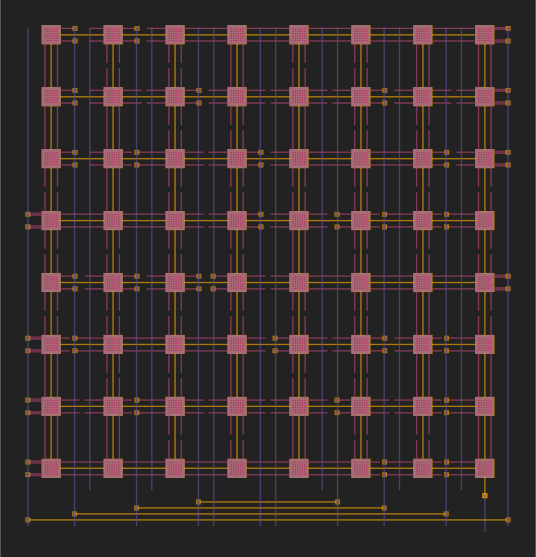

In [ ]:
dac_mimcap_component = create_6bit_dac_mimcap_array(sky130)
dac_mimcap_component.name = "6bit_DAC_MIMCAP_Array"
dac_mimcap_component.write_gds("mimcap_arr.gds")
display_gds("mimcap_arr.gds", scale=0.3)
